In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import shutil
import zipfile
import glob
import os
import time

In [21]:
train_dir = os.path.join(os.getcwd(), 'TB_Chest_Radiography_Database/train')
test_dir = os.path.join(os.getcwd(), 'TB_Chest_Radiography_Database/test')

print(f'the number of train set : {len(os.listdir(train_dir))}')
print(f'the number of test set : {len(os.listdir(test_dir))}')


normal_files = [f'Normal-{i}.png' for i in range(1,3500)]
tuberculosis_files = [f'Tuberculosis-{i}.png' for i in range(1,700)]


the number of train set : 3360
the number of test set : 840


In [22]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, files, root, mode='train', transform=None):
        self.files = files
        self.root = root
        self.mode = mode
        self.transform=transform
        
        if 'Normal' in files[0]:
            self.label = 0

        else:
            self.label = 1
        
    def __len__(self):
        return len(self.files)

        
        
    def __getitem__(self, index):
        img = PIL.Image.open(os.path.join(self.root, self.files[index]))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            return img, np.array([self.label])
        else:
            return img, self.files[index]


In [23]:
from PIL import Image, ImageOps, ImageFilter

class SmothImage(object):

    def __call__(self,image):
        
        return image.filter(ImageFilter.SMOOTH_MORE)

class ContrastBrightness(object):
    """Image pre-processing.

    alpha = 1.0 # Simple contrast control [1.0-3.0]
    beta = 0    # Simple brightness control [0-100]
    """
    
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta
    
    def __call__(self,image,):
        image = np.array(image)
        for y in range(image.shape[0]):
            for x in range(image.shape[1]):
                image[y,x] = np.clip(self.alpha*image[y,x] + self.beta, 0, 255)

                return Image.fromarray(np.uint8(image)*255)

class HistEqualization(object):
    """Image pre-processing.

    Equalize the image historgram
    """
    
    def __call__(self,image):
        
        return ImageOps.equalize(image, mask = None) 
            
            
            
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256,256)),
    torchvision.transforms.RandomCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.Grayscale(num_output_channels=3),
    ContrastBrightness(1.2,25),
    HistEqualization(),
    SmothImage(),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize([0.4990189, 0.49874797, 0.4984631], [0.21823819, 0.24591278, 0.22876337]),
])
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256,256)),
    torchvision.transforms.RandomCrop(224),
    torchvision.transforms.Grayscale(num_output_channels=3),
    ContrastBrightness(1.2,25),
    HistEqualization(),
    SmothImage(),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize([0.5066209, 0.50000274, 0.49914467], [0.20135736, 0.22966754, 0.188137]),
])

'''
0.4990189 0.49874797 0.4984631
0.21823819 0.24591278 0.22876337
0.5066209 0.50000274 0.49914467
0.20135736 0.22966754 0.188137

'''


'\n0.4990189 0.49874797 0.4984631\n0.21823819 0.24591278 0.22876337\n0.5066209 0.50000274 0.49914467\n0.20135736 0.22966754 0.188137\n\n'

In [24]:

train_normal_dataset = CustomDataset(normal_files[:2800], train_dir, transform=train_transform)
train_tuberculosis_dataset = CustomDataset(tuberculosis_files[:560], train_dir, transform=train_transform)
test_normal_dataset = CustomDataset(normal_files[2800:], test_dir, transform=test_transform)
test_tuberculosis_dataset = CustomDataset(tuberculosis_files[560:], test_dir, transform=test_transform)

train_dataset = torch.utils.data.ConcatDataset([train_normal_dataset, train_tuberculosis_dataset])
test_dataset = torch.utils.data.ConcatDataset([test_normal_dataset, test_tuberculosis_dataset])



In [25]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

train_norm_loader = torch.utils.data.DataLoader(train_dataset, batch_size=3360, shuffle=True)
test_norm_loader = torch.utils.data.DataLoader(test_dataset, batch_size=840, shuffle=True)


'''
#samples, labels = iter(train_norm_loader).next()    ##mean: 0.5291, std: 0.2344

meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x,_ in train_norm_loader]
stdRGB = [np.std(x.numpy(), axis=(1,2)) for x,_ in train_norm_loader]

meanR = np.mean([m[0] for m in meanRGB])
meanG = np.mean([m[1] for m in meanRGB])
meanB = np.mean([m[2] for m in meanRGB])

stdR = np.mean([s[0] for s in stdRGB])
stdG = np.mean([s[1] for s in stdRGB])
stdB = np.mean([s[2] for s in stdRGB])

print(meanR, meanG, meanB)
print(stdR, stdG, stdB)

meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x,_ in test_norm_loader]
stdRGB = [np.std(x.numpy(), axis=(1,2)) for x,_ in test_norm_loader]

meanR = np.mean([m[0] for m in meanRGB])
meanG = np.mean([m[1] for m in meanRGB])
meanB = np.mean([m[2] for m in meanRGB])

stdR = np.mean([s[0] for s in stdRGB])
stdG = np.mean([s[1] for s in stdRGB])
stdB = np.mean([s[2] for s in stdRGB])
print(meanR, meanG, meanB)
print(stdR, stdG, stdB)
'''




'\n#samples, labels = iter(train_norm_loader).next()    ##mean: 0.5291, std: 0.2344\n\nmeanRGB = [np.mean(x.numpy(), axis=(1,2)) for x,_ in train_norm_loader]\nstdRGB = [np.std(x.numpy(), axis=(1,2)) for x,_ in train_norm_loader]\n\nmeanR = np.mean([m[0] for m in meanRGB])\nmeanG = np.mean([m[1] for m in meanRGB])\nmeanB = np.mean([m[2] for m in meanRGB])\n\nstdR = np.mean([s[0] for s in stdRGB])\nstdG = np.mean([s[1] for s in stdRGB])\nstdB = np.mean([s[2] for s in stdRGB])\n\nprint(meanR, meanG, meanB)\nprint(stdR, stdG, stdB)\n\nmeanRGB = [np.mean(x.numpy(), axis=(1,2)) for x,_ in test_norm_loader]\nstdRGB = [np.std(x.numpy(), axis=(1,2)) for x,_ in test_norm_loader]\n\nmeanR = np.mean([m[0] for m in meanRGB])\nmeanG = np.mean([m[1] for m in meanRGB])\nmeanB = np.mean([m[2] for m in meanRGB])\n\nstdR = np.mean([s[0] for s in stdRGB])\nstdG = np.mean([s[1] for s in stdRGB])\nstdB = np.mean([s[2] for s in stdRGB])\nprint(meanR, meanG, meanB)\nprint(stdR, stdG, stdB)\n'

torch.Size([3, 224, 224])
torch.Size([1])


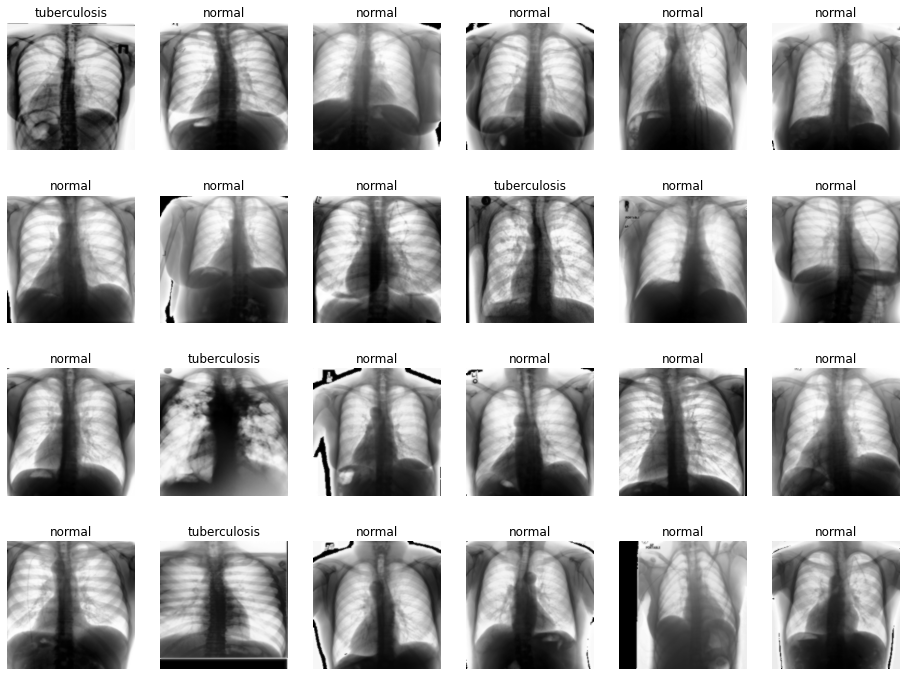

In [26]:
samples, labels = iter(train_loader).next()
classes = {0:'normal', 1:'tuberculosis'}
fig = plt.figure(figsize=(16,24))


for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
    
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)
print(samples[i].shape)
print(labels[i].shape)



In [27]:
device='cuda' if torch.cuda.is_available() else 'cpu'
print(device)


cuda


In [28]:
import torch.nn as nn


class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        # BatchNorm에 bias가 포함되어 있으므로, conv2d는 bias=False로 설정합니다.
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion),
        )

        # identity mapping, input과 output의 feature map size, filter 수가 동일한 경우 사용.
        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        # projection mapping using 1x1conv
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x


class BottleNeck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*BottleNeck.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*BottleNeck.expansion)
            )
            
    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x

class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes=2, init_weights=True):
        super().__init__()

        self.in_channels=64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # weights inittialization
        if init_weights:
            self._initialize_weights()

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self,x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        x = self.conv3_x(output)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    # define weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def resnet18():
    return ResNet(BasicBlock, [2,2,2,2])

def resnet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50():
    return ResNet(BottleNeck, [3,4,6,3])

def resnet101():
    return ResNet(BottleNeck, [3, 4, 23, 3])

def resnet152():
    return ResNet(BottleNeck, [3, 8, 36, 3])

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resnet50().to(device)
x = torch.randn(3, 3,224, 224).to(device)
output = model(x)
print(output.size())


torch.Size([3, 2])


In [30]:
!pip install torchsummary
from torchsummary import summary




model.cuda()
summary(model, input_size=(3,224,224))


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          

In [31]:
def fit(model, criterion, optimizer, epochs, train_loader, valid_loader):
    model.train()
    train_loss = 0
    train_acc = 0
    train_correct = 0
    
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    
    for epoch in range(epochs):
        start = time.time()
        
        for train_x, train_y in train_loader:
            model.train()
            #train_y = train_y.type(torch.LongTensor)
            train_y = train_y.squeeze(1)
            train_x, train_y = train_x.to(device), train_y.to(device).long()
            optimizer.zero_grad()
            pred = model(train_x)
            _, preds = torch.max(pred, 1)
            #print(pred.shape)
            #print(train_y.shape)
            #print(pred.shape)
            loss = criterion(pred, train_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            #running_corrects += torch.sum(preds == labels.data)
            train_correct += torch.sum(preds.cpu() == train_y.data.cpu())
            
            #y_pred = pred.cpu()
            #print(y_pred)
            #y_pred[y_pred >= 0.5] = 1
            #y_pred[y_pred < 0.5] = 0
           
            
        # validation data check
        valid_loss = 0
        valid_acc = 0
        valid_correct = 0
        for valid_x, valid_y in valid_loader:
            with torch.no_grad():
                model.eval()
                #valid_y = valid_y.type(torch.LongTensor)
                valid_y = valid_y.squeeze(1)
                valid_x, valid_y = valid_x.to(device), valid_y.to(device).long()
                pred = model(valid_x)
                _, preds_val = torch.max(pred, 1)
                loss = criterion(pred, valid_y)
            valid_loss += loss.item()
            
            #running_corrects += torch.sum(preds == labels.data)
            valid_correct += torch.sum(preds_val.cpu() == valid_y.data.cpu())
            
            #y_pred = pred.cpu()
            #y_pred[y_pred >= 0.5] = 1
            #y_pred[y_pred < 0.5] = 0
            #valid_correct += y_pred.eq(valid_y.cpu()).int().sum()
            
        train_acc = train_correct/len(train_loader.dataset)
        valid_acc = valid_correct/len(valid_loader.dataset)
        print(f'{time.time() - start:.3f}sec : [Epoch {epoch+1}/{epochs}] -> train loss: {train_loss/len(train_loader):.4f}, train acc: {train_acc*100:.3f}% / valid loss: {valid_loss/len(valid_loader):.4f}, valid acc: {valid_acc*100:.3f}%')
        train_losses.append(train_loss/len(train_loader))
        train_accuracies.append(train_acc)
        valid_losses.append(valid_loss/len(valid_loader))
        valid_accuracies.append(valid_acc)
        
        train_loss = 0
        train_acc = 0
        train_correct = 0
    plt.plot(train_losses, label='loss')
    plt.plot(train_accuracies, label='accuracy')
    plt.legend()
    plt.title('train loss and accuracy')
    plt.show()
    plt.plot(valid_losses, label='loss')
    plt.plot(valid_accuracies, label='accuracy')
    plt.legend()
    plt.title('valid loss and accuracy')
    plt.show()



40.819sec : [Epoch 1/40] -> train loss: 0.2764, train acc: 90.268% / valid loss: 0.3116, valid acc: 91.289%
40.967sec : [Epoch 2/40] -> train loss: 0.2075, train acc: 93.244% / valid loss: 0.7313, valid acc: 74.702%
40.990sec : [Epoch 3/40] -> train loss: 0.1954, train acc: 93.423% / valid loss: 0.4850, valid acc: 82.936%
41.006sec : [Epoch 4/40] -> train loss: 0.1768, train acc: 94.494% / valid loss: 0.2251, valid acc: 92.243%
40.983sec : [Epoch 5/40] -> train loss: 0.1550, train acc: 94.732% / valid loss: 3.8174, valid acc: 16.706%
41.081sec : [Epoch 6/40] -> train loss: 0.1526, train acc: 95.030% / valid loss: 1.0327, valid acc: 48.210%
41.061sec : [Epoch 7/40] -> train loss: 0.1487, train acc: 94.762% / valid loss: 0.1679, valid acc: 93.079%
41.022sec : [Epoch 8/40] -> train loss: 0.1330, train acc: 95.714% / valid loss: 0.2077, valid acc: 93.795%
41.042sec : [Epoch 9/40] -> train loss: 0.1313, train acc: 95.476% / valid loss: 0.1336, valid acc: 95.107%
41.258sec : [Epoch 10/40] ->

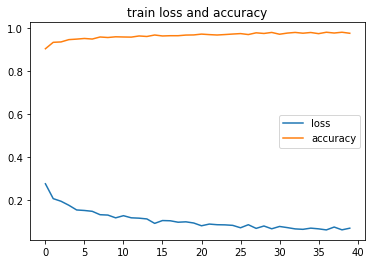

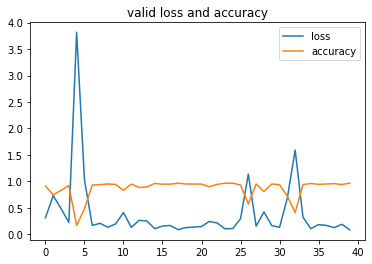

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

fit(model, criterion, optimizer, 40, train_loader, test_loader)

